# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [68]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [69]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [70]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))  #  Створюється Dataset з тензорів "x_train" і "y_train"
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)
# train_data.repeat(): додає повторення епох нескінченну кількість разів
# shuffle(5000): виконується перемішування даних в Dataset
# batch(batch_size): групує дані в батчі (пакети) розміру "batch_size"
# prefetch(1): додає можливість попереднього завантаження даних. В даному випадку, 1 означає, що буде завантажено один батч даних в оперативну пам'ять

In [71]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    # Шар для роботи з вагами та зсувами
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)

        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )  # задається тензор (матрицю) ваг з випадковими значеннями, взятими з нормального розподілу (розподіл Гаусса) розміром [in_features, out_features]
        # in_features - визначає кількість входів для кожного нейрона, out_features - кількість нейронів у шарі
        # tf.Variable(...): використовується для створення змінної TensorFlow, яку можна змінювати під час навчання моделі. Ваги мережі потрібно оновлювати під час процесу навчання
        # name="w": аргумент, який визначає ім'я цієї змінної, що може бути використане для отримання доступу до неї та ідентифікації її під час візуалізації моделі

        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        # tf.zeros([out_features]): створює тензор (масив) розміром [out_features], в якому всі значення встановлені на нуль

    def __call__(self, x, activation=0):
        # метод __call__ представляє собою операцію, яка викликається, коли екземпляр класу об'єкта використовується як функція. При виклику шару передається вхід x, а також параметр activation
        y = tf.matmul(x, self.w) + self.b  # операція матричного множення та подальшого додавання елементів вектора зсуву
        if activation != 0:
            return tf.nn.softmax(y) # перетворення виходів у ймовірністі, які можуть інтерпретуватися як ймовірність приналежності до кожного класу
        else:
            return tf.nn.sigmoid(y)  # поверне новий тензор з такими ж розмірами, як і вхідний, але кожен його елемент буде відповідати значенню сигмоїд-функції для відповідного елементу вхідного тензору

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(in_features=num_features, out_features=n_hidden_1, name="layer1")

    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(in_features=128, out_features=256, name="layer2")

    # Вихідний шар
    self.output_layer = DenseLayer(in_features=256, out_features=num_classes, name="output_layer")


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=1)
    x = self.layer2(x, activation=1)
    output = self.output_layer(x, activation=1)

    return output

In [72]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію

# Обчислення середніх крос-ентропійних втрат (cross-entropy loss) між one-hot закодованими мітками y_true та передбаченими ймовірностями y_pred
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)
    # y_true - вектор міток класів
    # tf.one_hot - перетворення вектора y_true у матрицю one_hot, де кожен рядок є одним зразком даних,
    # а стовпці відповідають унікальним класам. Якщо зразок належить класу, то відповідний стовпець міститиме 1, а решта - 0

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # y_pred - передбаченні значення моделі (в межах від 0 до 1)
    # 1e-9 - мале число, додається для того, щоб уникнути ділення на нуль. Тут воно використовується як нижня межа для обмеження
    # 1.0 - верхня межа для обмеження. Якщо значення y_pred більше 1, вони будуть замінені на 1
    # tf.clip_by_value - обмежує значення y_pred між вказаними межами. Всі значення, менше 1e-9, будуть встановлені на 1e-9, а всі значення, більше 1, будуть встановлені на 1

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))
    # y_true - one-hot закодовані мітки класів
    # tf.math.log(y_pred) - обчислює логарифм ймовірностей
    # y_true * tf.math.log(y_pred) - поелементне множення one-hot закодованих міток класів на логарифми ймовірностей
    # -tf.reduce_sum - обчислює суму всіх значень, а знак мінус вказує на те, що ми обчислюємо зворотню величину (втрати), а не значення функції корисності
    # tf.reduce_mean - обчислює середнє значення втрат для всіх прикладів у партії

# Як метрику якості використовуємо точність
# Обчислимо її як відношення правильно класифікованих екземплярів до загальної кількості екземплярів (як середнє арифметичне точності для кожного прикладу в батчі)
def accuracy(y_pred, y_true):
    # Отримаємо індекс максимального значення для кожного класу
    predicted_classes = tf.argmax(y_pred, axis=1)
    # y_pred - передбаченні значення моделі (в межах від 0 до 1)
    # tf.argmax - отримуємо індекс класу (максисимальне значення), який модель вважає найбільш ймовірним
    # axis=1 - максимальне значення шукається вздовж другої осі, тобто вздовж стовпців

    # Отримаємо індекси правильних класів
    y_true = tf.one_hot(y_true, depth=num_classes)
    true_classes = tf.argmax(y_true, axis=1)
    # y_true - one-hot закодовані мітки класів

    # Порівняємо передбачені та правильні класи
    correct_predictions = tf.equal(predicted_classes, true_classes)
    # tf.equal - порівнює елементи двох тензорів та повертає булевий тензор, де True вказує на правильне передбачення

    # Обчислимо середню точність
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, dtype=tf.float32))
    # tf.cast - використовується для перетворення булевого тензора correct_predictions на тензор з числовими значеннями (0 та 1)
    # tf.reduce_mean - обчислює середнє значення цього тензора, що відображає середню точність для всіх екземплярів

    return accuracy

In [73]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:  # обчислення градієнтів відносно змінних, які знаходяться всередині контексту
    pred = neural_net(input_x)  # передбачення мережі для вхідних даних
    loss = cross_entropy(pred, output_y)  # значення функції втрат

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо (оновимо) параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    # zip(gradients, trainable_variables) - градієнти (gradients), які були обчислені раніше за допомогою tf.GradientTape,
    # і список оптимізованих параметрів (trainable_variables) об'єднуються в кортежі за допомогою zip. Кожний градієнт відповідає відповідній змінній
    # apply_gradients приймає кортеж з пар (gradient, variable) для кожної змінної і застосовує градієнт до цієї змінної відповідно до вибраного алгоритму оптимізації (SGD)

  return pred, loss

In [74]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # з кожною ітерацією циклу отримується новий пакет даних (batch_x, batch_y) з тренувального датасету
    # Навчання моделі
    train_process = train(neural_net, batch_x, batch_y)
    # Поточне значення втрат
    current_loss = train_process[1]
    # Поточне значення точності
    current_accuracy = accuracy(train_process[0], batch_y)

    if step % display_step == 0:  # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності
        # pred = neural_net(batch_x)  # оновлюємо прогнози для обчислення точності для вхідних даних

        # current_loss = train_process[1]
        # current_accuracy = accuracy(pred, batch_y)

        # current_loss & current_accuracy мають вигляд tf.Tensor(338.40845, shape=(), dtype=tf.float32)
        loss_history.append(current_loss.numpy())
        accuracy_history.append(current_accuracy.numpy())

print(loss_history)
print(accuracy_history)

[590.6406, 587.2555, 587.9363, 585.3779, 583.9649, 580.1404, 577.54614, 571.8108, 558.50903, 543.8373, 532.9619, 519.09326, 514.5198, 479.38956, 472.7851, 455.7624, 442.33954, 450.86182, 437.0551, 430.69522, 406.7787, 397.87775, 385.146, 369.1018, 392.4644, 397.6445, 381.05566, 350.38104, 359.4832, 364.22736]
[0.0859375, 0.11328125, 0.1015625, 0.1640625, 0.171875, 0.1796875, 0.1796875, 0.1640625, 0.27734375, 0.26171875, 0.28515625, 0.3046875, 0.25, 0.3515625, 0.39453125, 0.37890625, 0.4140625, 0.35546875, 0.44921875, 0.37890625, 0.40625, 0.42578125, 0.44921875, 0.42578125, 0.37890625, 0.421875, 0.44140625, 0.46484375, 0.46484375, 0.39453125]


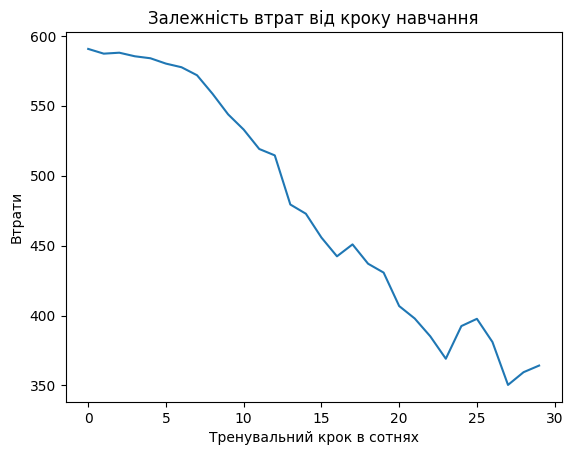

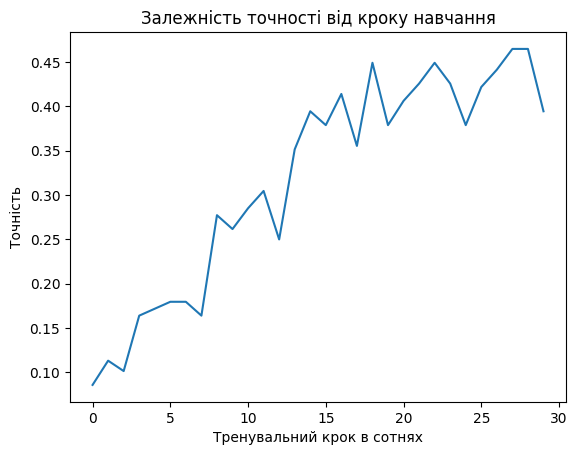

In [75]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(loss_history)
plt.xlabel('Тренувальний крок в сотнях')
plt.ylabel('Втрати')
plt.title('Залежність втрат від кроку навчання')
plt.show()

# Виведіть графік точності
plt.plot(accuracy_history)
plt.xlabel('Тренувальний крок в сотнях')
plt.ylabel('Точність')
plt.title('Залежність точності від кроку навчання')
plt.show()

In [76]:
# Обчисліть точність навченої нейромережі
predictions = neural_net(x_test)  # отримання прогнозів на тестовій вибірці
accuracy_total = accuracy(predictions, y_test)  # розрахунок точності
print(accuracy_total.numpy())  # вивід значення точності з отриманого тензора

0.4648


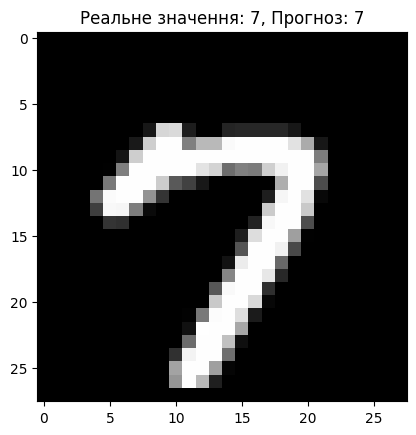

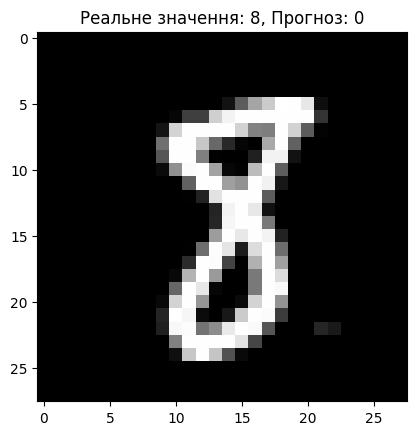

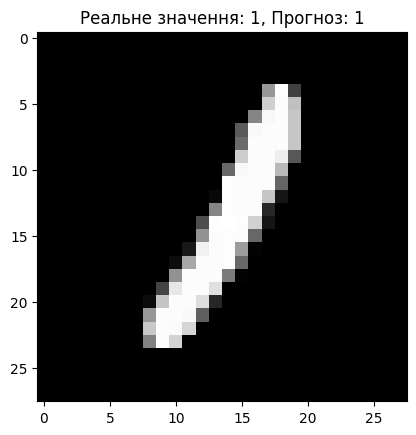

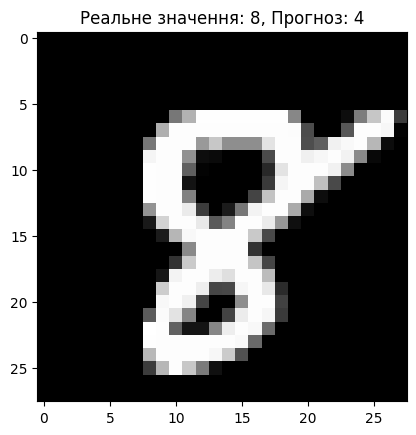

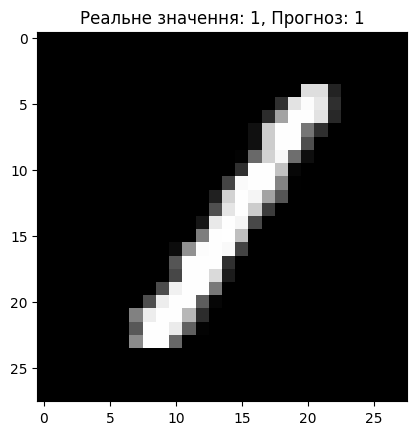

In [78]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється ваша нейронна мережа, і якщо так, то як часто?

from random import sample  # для випадкового вибору певної кількості елементів із заданого об'єкту

# Виберемо з тестової вибірки 10 випадкових індексів зображень
random_indices = sample(range(len(x_test)), 10)

# Визначемо відповідні до обраних індексів зображення та мітки з тестового набору даних
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]  # на виході масив міток

# Зробимо прогноз для обраних випадкових зображень
sample_predictions = neural_net(sample_images)  # на виході тензор 10х10
# В такому тензорі в кожному рядку по 10 чисел-вирогідностей, індекс найбільшої вирогідності відповідає цифрі

# Виведемо зображень та прогнозів для 5 зображень з 10
for i in range(5):
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Реальне значення: {sample_labels[i]}, Прогноз: {np.argmax(sample_predictions[i])}")
    plt.show()

Висновок: з 5 зображень коректно кваліфіковано 3. Це відповідає розрахунковій середній точності 0.4648.
Точність невисока.